# Проект 1

**Представьте, что вы работаете в компании, которая разрабатывает мобильные игры.**
**К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:**

* **В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.**
* **Помимо этого, в компании провели A/B тестирование наборов акционных предложений.**
**На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик**
**стоит принять правильное решение.**
* **Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.**

<div class="alert alert-block alert-danger"
<b>
<ol>
    
**Задача 1**

**Retention – один из самых важных показателей в компании.**
**Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).**
**Данные лежат в папке shared и имеют следующую структуру:**
    
* **shared/problem1-reg_data.csv** – данные о времени регистрации
* **shared/problem1-auth_data.csv** – данные о времени захода пользователей в игру

**Функция должна быть написана на python.** 
**В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.**  
</ol>
</b>
</div>

<div class="alert alert-block alert-info"
<b>
Для начала подключим необходимые библиотеки
</b>
</div

In [1]:
import pandas as pd
import numpy as np
from operator import attrgetter
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import scipy
from scipy import stats
from scipy.stats import norm
import requests 
from urllib.parse import urlencode

<div class="alert alert-block alert-info"
<b>
Теперь подгрузим данные о времени регистрации
</b>
</div

In [2]:
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv',sep=';')
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


<div class="alert alert-block alert-info"
<b>
А также данные о времени захода пользователей в игру
</b>
</div

In [3]:
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv',sep=';')
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


<div class="alert alert-block alert-info"
<b>
Далее проведем предварительную проверку данных:

* типы данных в датафреймах

</b>
</div

In [4]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [5]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

<div class="alert alert-block alert-info"
<b>

* наличие пустых значений

</b>
</div

In [6]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [7]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

<div class="alert alert-block alert-info"
<b>

* размер фреймов

</b>
</div

In [8]:
reg_data.shape

(1000000, 2)

In [9]:
auth_data.shape

(9601013, 2)

<div class="alert alert-block alert-info"
<b>

* число уникальных пользователей

</b>
</div

In [10]:
reg_data.uid.nunique()

1000000

In [11]:
auth_data.uid.nunique()

1000000

<div class="alert alert-block alert-info"
<b>

Сконвертируем столбцы с временем в human-readable формат

</b>
</div

In [12]:
reg_data.reg_ts = pd.to_datetime(reg_data.reg_ts, unit='s')

In [13]:
auth_data.auth_ts = pd.to_datetime(auth_data.auth_ts, unit='s')

<div class="alert alert-block alert-info"
<b>

Соберем вместе данные для работы

</b>
</div

In [14]:
df = reg_data.merge(auth_data, on='uid')
df.head()

,reg_ts,uid,auth_ts
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09
2,1999-07-22 22:38:09,2,1999-07-25 16:46:46
3,1999-07-22 22:38:09,2,1999-07-31 03:50:15
4,1999-07-22 22:38:09,2,1999-08-05 17:49:39


<div class="alert alert-block alert-info"
<b>

Посмотрим на разброс дат

</b>
</div


In [15]:
df[['reg_ts','auth_ts']].max()

reg_ts    2020-09-23 15:17:24
auth_ts   2020-09-23 15:17:24
dtype: datetime64[ns]

In [16]:
df[['reg_ts','auth_ts']].min()

reg_ts    1998-11-18 09:43:43
auth_ts   1998-11-18 09:43:43
dtype: datetime64[ns]

<div class="alert alert-block alert-info"
<b>

Нетрудно заметить, что разбор данных довольно большой 

По заданию требуется найти retention по дням от даты регистрации игрока

Поэтому целесообразнее рассчитывать retention в рамках недели 

</b>
</div

In [17]:
def cohort_retention(period,frame,reg_date,auth_date,cus_id):
    data = frame.query('reg_ts >= @period')
    
    data[reg_date] = pd.to_datetime(data[reg_date]).dt.to_period("d")
    data[auth_date] = pd.to_datetime(data[auth_date]).dt.to_period("d")
    data['days'] = (data[auth_date] - data[reg_date]).apply(attrgetter('n'))
    
    coh = data.pivot_table(index = reg_date, columns='days', values = cus_id, aggfunc = 'nunique')
    coh = coh.div(coh.iloc[:,0], axis = 0)

    final_table = (coh
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту

    return final_table

In [18]:
cohort_retention(period="2020-09-17", frame=df, reg_date='reg_ts', auth_date='auth_ts', cus_id='uid')

days,0,1,2,3,4,5,6
reg_ts,,,,,,,
2020-09-17,100.00%,1.66%,4.30%,4.55%,5.47%,6.27%,4.24%
2020-09-18,100.00%,1.90%,4.54%,4.23%,5.21%,3.74%,
2020-09-19,100.00%,1.84%,3.55%,4.71%,3.49%,,
2020-09-20,100.00%,2.44%,4.34%,2.38%,,,
2020-09-21,100.00%,1.89%,2.99%,,,,
2020-09-22,100.00%,0.85%,,,,,
2020-09-23,100.00%,,,,,,


<div class="alert alert-block alert-danger"
<b>
<ol>
    
**Задача 2**
    
**Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений.** **Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103** **оказались платящими, а в тестовой – 1805 из 202667.**

**Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?**       
    
</ol>
</b>
</div>

<div class="alert alert-block alert-info"
<b>

Данные предоставили в виде файла, загруженного на Яндекс Диск. Подгрузим их.

</b>
</div


In [19]:
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key_result = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'  

# получаем url 
final_url_result = base_url + urlencode(dict(public_key=public_key_result)) 

response_result = requests.get(final_url_result) 

download_url_result = response_result.json()['href'] 
        
# загружаем файл  
download_response_result = requests.get(download_url_result) 

result = pd.read_csv(download_url_result, sep=';') 

<div class="alert alert-block alert-info"
<b>
Посмотрим на данные.
Таблица с результатами A/B теста имеет три столбца:

* user_id - идентификатор пользователя
* revenue - доход с пользователя
* testgroup - тестовая группа (a либо b)

</b>
</div

In [20]:
result.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


<div class="alert alert-block alert-info"
<b>

Проверим типы данных, наличие пустых значений и дубликатов 

</b>
</div

In [21]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [22]:
result.duplicated().sum()

0

<div class="alert alert-block alert-info"
<b>

## **Conversion Rate**

**По заданию предлагается выбрать необходимые метрики для анализа.Так как располагаем данными с доходом от каждого пользователя, поработаем с конверсией в покупку.**

**Однако для начала проверим, сколько имеем пользователей в каждой из групп.**

</b>
</div


In [23]:
#общее число пользователей
all_users = result.groupby('testgroup',as_index=False).agg({'user_id':'nunique'})
all_users

,testgroup,user_id
0,a,202103
1,b,202667


In [24]:
#число пользователей, которые выполнили целевое действие (сделали покупку)
purch = result.query('revenue>0').groupby('testgroup',as_index=False).agg({'user_id':'nunique'})
purch

,testgroup,user_id
0,a,1928
1,b,1805


In [25]:
#переименуем колонку с пользователями 
all_users = all_users.rename(columns={'user_id':'all_users'})

In [26]:
#объединим датафреймы 
conv = all_users.merge(purch,on='testgroup')
conv

,testgroup,all_users,user_id
0,a,202103,1928
1,b,202667,1805


<div class="alert alert-block alert-info"
<b>

Визуализируем результат

</b>
</div

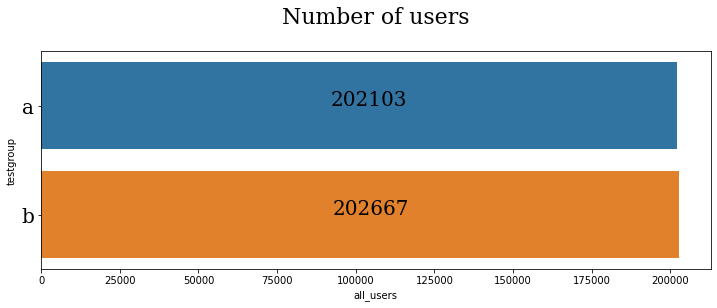

In [27]:
plt.figure(figsize=(12, 4))
sns.barplot(x='all_users', y='testgroup', data=conv)

for i in range(len(conv)):
    plt.text(s = conv['all_users'][i],
             x = conv['all_users'][i]-110000,
             y = i,
             color = 'black',
             fontsize = 20,
             family = 'serif')

plt.title(label = 'Number of users',
          color = 'black',
          fontsize = 22,
          x = 0.5,
          y = 1.1,
          family = 'serif')

plt.yticks(color = 'black',
           fontsize = 20,
           family = 'serif')
plt.show()

<div class="alert alert-block alert-info"
<b>
Число пользователей примерно равно. Так и должно быть.
</b>
</div

In [28]:
#посчитаем конверсию
conv['conversion'] = ((conv.user_id / conv.all_users)*100).round(2)
conv

,testgroup,all_users,user_id,conversion
0,a,202103,1928,0.95
1,b,202667,1805,0.89


In [29]:
#посчитаем величину разницы конверсии в разбивке по группе
(conv.conversion[0] - conv.conversion[1]).round(2)

0.06

<div class="alert alert-block alert-info"
<b>

Визуализируем результат для наглядности

</b>
</div

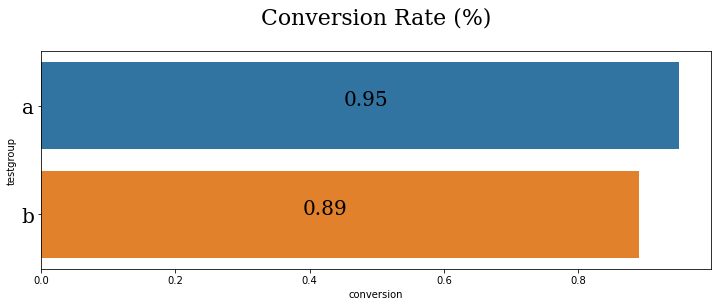

In [30]:
plt.figure(figsize=(12, 4))
sns.barplot(x='conversion', y='testgroup', data=conv)

for i in range(len(conv)):
    plt.text(s = conv['conversion'][i],
             x = conv['conversion'][i]-0.5,
             y = i,
             color = 'black',
             fontsize = 20,
             family = 'serif')

plt.title(label = 'Conversion Rate (%)',
          color = 'black',
          fontsize = 22,
          x = 0.5,
          y = 1.1,
          family = 'serif')

plt.yticks(color = 'black',
           fontsize = 20,
           family = 'serif')
plt.show()


<div class="alert alert-block alert-info"
<b>

Нетрудно заметить, что конверсия в группе a больше, чем в группе b на 0,06%.

Теперь необходимо проверить статистическую значимость.

Поскольку работаем с конверсией, которая является категориальной переменной, необходимо использовать тест на независимость Хи-квадрат.

Нулевая гипотеза предполагает, что разница между средними значениями показателя в сегментах незначительна.

</b>
</div

In [31]:
#для удобства добавим новый столбец в исходный датафрейм, где будет указываться наличие/отсутствие покупки у пользователей
pur = []
for i in result.revenue:
    if i == 0:
        pur.append('no_purchase')
    else:
        pur.append('purchase')
result['purchase'] = pur
result.head()

,user_id,revenue,testgroup,purchase
0,1,0,b,no_purchase
1,2,0,a,no_purchase
2,3,0,a,no_purchase
3,4,0,b,no_purchase
4,5,0,b,no_purchase


In [32]:
#соберем таблицу сопряженности
for_chi2 = pd.crosstab(result['testgroup'], result['purchase'])
for_chi2

purchase,no_purchase,purchase
testgroup,,
a,200175,1928
b,200862,1805


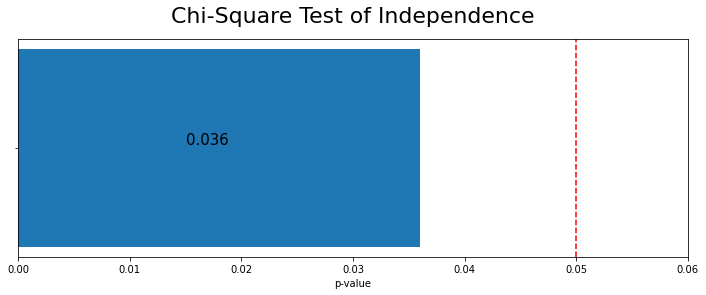

Нулевая гипотеза отклоняется, есть статистически значимые различия


In [33]:
#проведем тест на независимость Хи-квадрат 
a = 0.05
p = (stats.chi2_contingency(for_chi2)[1]).round(3)



fig, ax = plt.subplots(figsize=(12, 4))
ax.barh([''],[p])


ax.set_title('Chi-Square Test of Independence', color = 'black', fontsize=22, x = 0.5, y = 1.05)

ax.axvline(0.05, ls='--', color='r')

ax.set(xlim=[0, 0.06], xlabel='p-value')

ax.text(0.015, 0.015, p, color='black', fontsize=15)


plt.show()

if p < a:
    print('Нулевая гипотеза отклоняется, есть статистически значимые различия')
else:
    print('Нулевая гипотеза не отклоняется, нет статистически значимые различия')

<div class="alert alert-block alert-info"
<b>

Таким образом, можно сделать вывод о том, что различия в конверсии в группе a и b статистически значимы. 

Это значит, что набор акционных предложений для контрольной группы a положительно повлиял на пользователей,
побудив их совершать покупки. 

</b>
</div

<div class="alert alert-block alert-info"
<b>

## **ARPPU & ARPU**

**В результатах A/B теста имеется revenue.** **Поэтому поработаем с показателями доходов: ARPPU и ARPU.** 

**Однако прежде чем приступить к расчету данных метрик, посмотрим как распределяется revenue.**

</b>
</div

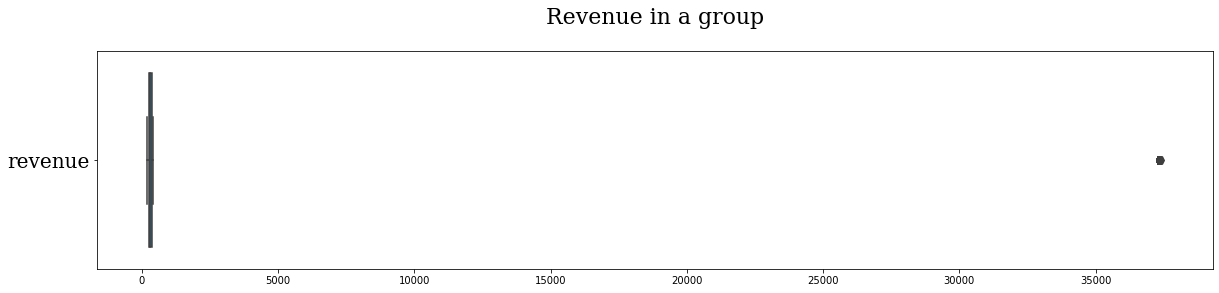

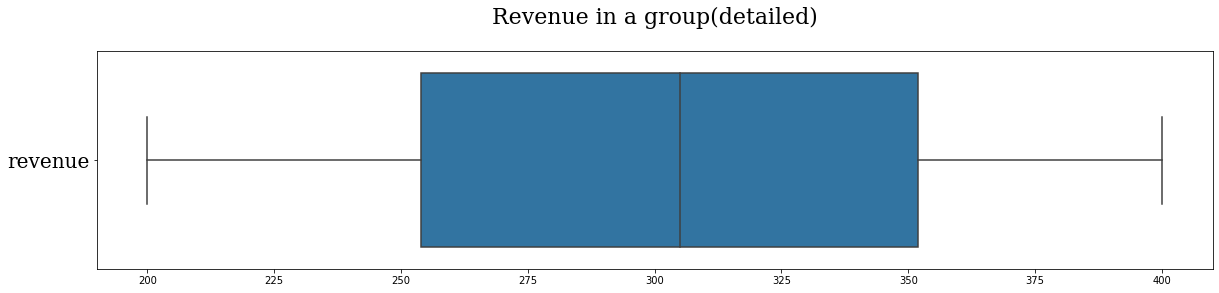

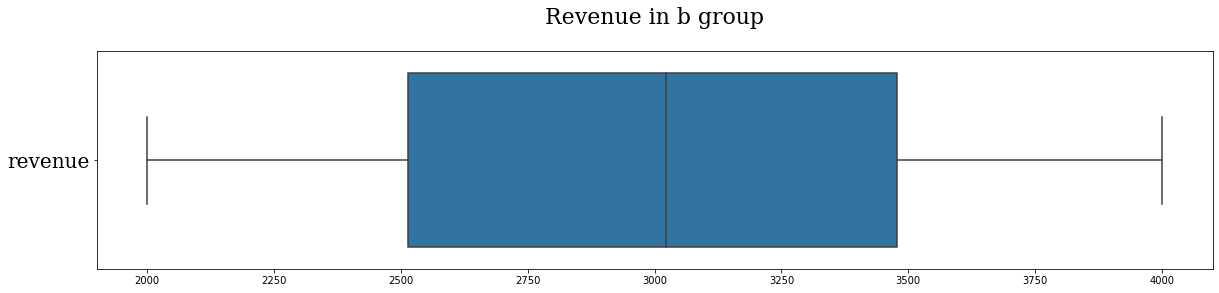

Минимальный доход в группе a: 200 
Медианный доход в группе a: 311.0 
Максимальный доход в группе a: 37433 

Минимальный доход в группе b: 2000 
Медианный доход в группе b: 3022.0 
Максимальный доход в группе b: 4000


In [34]:
plt.figure(figsize=(20, 4))
sns.boxplot(data=result.query("testgroup == 'a' & revenue>0")[['revenue']], orient="h")
plt.title(label = 'Revenue in a group',
          color = 'black',
          fontsize = 22,
          x = 0.5,
          y = 1.1,
          family = 'serif')
plt.yticks(color = 'black',
           fontsize = 20,
           family = 'serif')
plt.show()


plt.figure(figsize=(20, 4))
sns.boxplot(data=result.query("testgroup == 'a' & 0<revenue<15000")[['revenue']], orient="h")
plt.title(label = 'Revenue in a group(detailed)',
          color = 'black',
          fontsize = 22,
          x = 0.5,
          y = 1.1,
          family = 'serif')
plt.yticks(color = 'black',
           fontsize = 20,
           family = 'serif')
plt.show()


plt.figure(figsize=(20, 4))
sns.boxplot(data=result.query("testgroup == 'b' & revenue > 0")[['revenue']], orient="h")
plt.title(label = 'Revenue in b group',
          color = 'black',
          fontsize = 22,
          x = 0.5,
          y = 1.1,
          family = 'serif')
plt.yticks(color = 'black',
           fontsize = 20,
           family = 'serif')
plt.show()

print(
'Минимальный доход в группе a:',result.query('testgroup == "a" & revenue > 0')['revenue'].min(),   
'\nМедианный доход в группе a:',result.query('testgroup == "a" & revenue > 0')['revenue'].median(),   
'\nМаксимальный доход в группе a:',result.query('testgroup == "a" & revenue > 0')['revenue'].max(),

'\n\nМинимальный доход в группе b:',result.query('testgroup == "b" & revenue > 0')['revenue'].min(),  
'\nМедианный доход в группе b:',result.query('testgroup == "b" & revenue > 0')['revenue'].median(), 
'\nМаксимальный доход в группе b:',result.query('testgroup == "b" & revenue > 0')['revenue'].max()
)

<div class="alert alert-block alert-info"
<b>

Boxplot показывает минимум, первый квартиль, медиану, третий квартиль и максимум. 

Сразу заметно, что медианное значение дохода в группе a примерно в 10 раз меньше, чем в группе b. 

Размах в группе b много меньше, чем в группе a. В группе а распредление неравномерное - покупки, в основном, либо слишком дорогие, либо совсем недорогие. В группе b другая картина - распределение довольно равномерное.

Теперь посмотрим на **ARPPU** и **ARPU.**

</b>
</div

In [35]:
#число покупок
df = result.groupby('testgroup', as_index = False) \
           .agg({'revenue' : 'sum'})
#ARPPU
df['ARPPU'] = (result\
                    .query('revenue > 0')\
                    .groupby('testgroup',as_index=False)\
                    .agg({'revenue':'mean'})).round(2).revenue
#ARPU
df['ARPU'] = (result\
                    .groupby('testgroup',as_index=False)\
                    .agg({'revenue':'mean'})).round(2).revenue

df

,testgroup,revenue,ARPPU,ARPU
0,a,5136189,2664.00,25.41
1,b,5421603,3003.66,26.75


<div class="alert alert-block alert-info"
<b>

Визуализируем результат 

</b>
</div

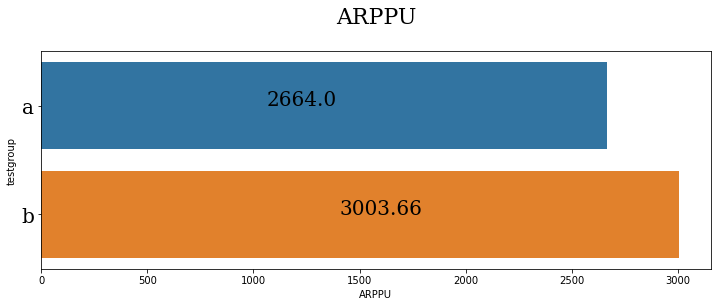

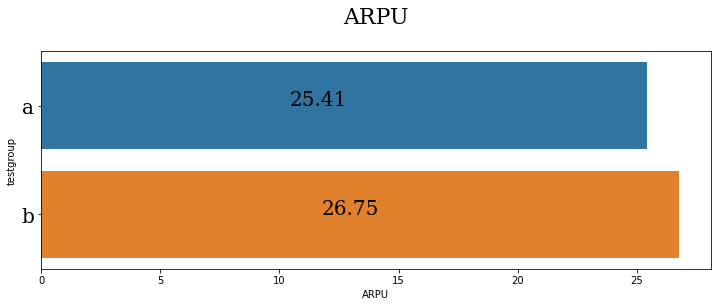

Разница(%) ARPPU в группах: 13.0
Разница(%) ARPU в группах: 5.0


In [36]:
plt.figure(figsize=(12, 4))
sns.barplot(x='ARPPU', y='testgroup', data=df)

for i in range(len(conv)):
    plt.text(s = df['ARPPU'][i],
             x = df['ARPPU'][i]-1600,
             y = i,
             color = 'black',
             fontsize = 20,
             family = 'serif')

plt.title(label = 'ARPPU',
          color = 'black',
          fontsize = 22,
          x = 0.5,
          y = 1.1,
          family = 'serif')

plt.yticks(color = 'black',
           fontsize = 20,
           family = 'serif')
plt.show()



plt.figure(figsize=(12, 4))
sns.barplot(x='ARPU', y='testgroup', data=df)

for i in range(len(conv)):
    plt.text(s = df['ARPU'][i],
             x = df['ARPU'][i]-15,
             y = i,
             color = 'black',
             fontsize = 20,
             family = 'serif')
    
plt.title(label = 'ARPU',
          color = 'black',
          fontsize = 22,
          x = 0.5,
          y = 1.1,
          family = 'serif')

plt.yticks(color = 'black',
           fontsize = 20,
           family = 'serif')
plt.show()
print('Разница(%) ARPPU в группах:', (abs(df.ARPPU[0] - df.ARPPU[1])/df.ARPPU[0]*100).round())
print('Разница(%) ARPU в группах:', (abs(df.ARPU[0] - df.ARPU[1])/df.ARPU[0]*100).round())

<div class="alert alert-block alert-info"
<b>

Нетрудно заметить, что ARPPU, как и ARPU в группе b больше, чем в группе a на 13% и 5% соответственно.

Теперь необходимо проверить, имеем ли мы дело со статистически значимыми различиями. Используем ttest и bootstrap.

ARPPU
* T-test

  Нулевая гипотеза: Разницы между ARPPU в тестовой(b) и контрольной(a) группе нет.
</b>
</div

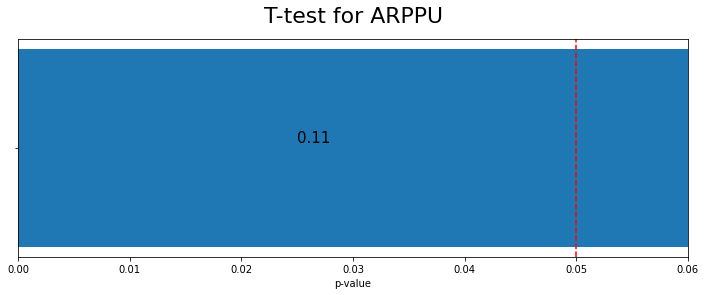

Нулевая гипотеза не отклоняется, нет статистически значимой разницы


In [37]:
a = 0.05
p = (stats.ttest_ind(result.query('testgroup == "a" & revenue>0')['revenue'],\
                     result.query('testgroup == "b" & revenue>0')['revenue'])[1]).round(2)

fig, ax = plt.subplots(figsize=(12, 4))
ax.barh([''],[p])

ax.set_title('T-test for ARPPU', color = 'black', fontsize=22, x = 0.5, y = 1.05)

ax.axvline(0.05, ls='--', color='r')

ax.set(xlim=[0, 0.06], xlabel='p-value')
ax.text(0.025, 0.025, p, color='black', fontsize=15)

plt.show()

if p < a:
    print('Нулевая гипотеза отклоняется, есть статистически значимая разница')
else:
    print('Нулевая гипотеза не отклоняется, нет статистически значимой разницы')


<div class="alert alert-block alert-info"
<b>

ARPPU
* Bootstrap
    
    Если ноль находится вне доверительного интервала, то отличия статистически значимы, иначе нет. 
</b>
</div

In [38]:
from tqdm.auto import tqdm
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title('Histogram of boot_data ARPPU')
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

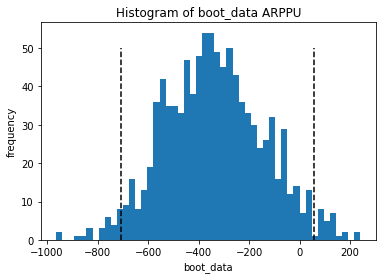

p_value: 0.08


,0
0.025,-708.549365
0.975,57.640132


In [39]:
booted_data_arppu = get_bootstrap(      
    result.query('testgroup == "a" & revenue>0')['revenue'],
    result.query('testgroup == "b" & revenue>0')['revenue'],
    boot_it = 1000,
    statistic = np.mean, 
    bootstrap_conf_level = 0.95)
print("p_value:", booted_data_arppu["p_value"].round(2))
booted_data_arppu["quants"]

Ноль входит в доверительный интервал, значит статистически значимых различий ARPPU в группе a и b нет.

<div class="alert alert-block alert-info"
<b>

ARPU
* T-test

  Нулевая гипотеза: Разницы между ARPU в тестовой(b) и контрольной(a) группе нет.
</b>
</div

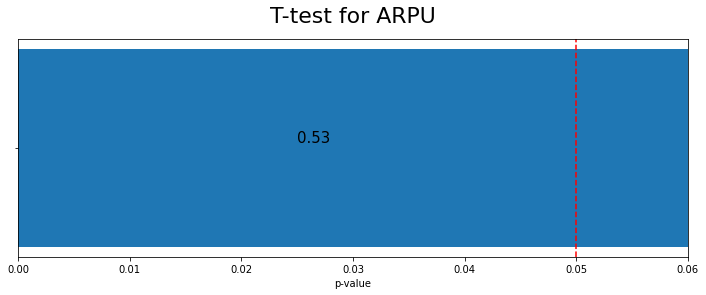

Нулевая гипотеза не отклоняется, нет статистически значимой разницы


In [40]:
a = 0.05
p = (stats.ttest_ind(result.query('testgroup == "a"')['revenue'],\
                     result.query('testgroup == "b"')['revenue'])[1]).round(2)

fig, ax = plt.subplots(figsize=(12, 4))
ax.barh([''],[p])

ax.set_title('T-test for ARPU', color = 'black', fontsize=22, x = 0.5, y = 1.05)

ax.axvline(0.05, ls='--', color='r')

ax.set(xlim=[0, 0.06], xlabel='p-value')
ax.text(0.025, 0.025, p, color='black', fontsize=15)

plt.show()

if p < a:
    print('Нулевая гипотеза отклоняется, есть статистически значимая разница')
else:
    print('Нулевая гипотеза не отклоняется, нет статистически значимой разницы')
    

<div class="alert alert-block alert-info"
<b>

ARPU
* Bootstrap
    
    Если ноль находится вне доверительного интервала, то отличия статистически значимы, иначе нет.  
</b>
</div

In [41]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title('Histogram of boot_data')
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

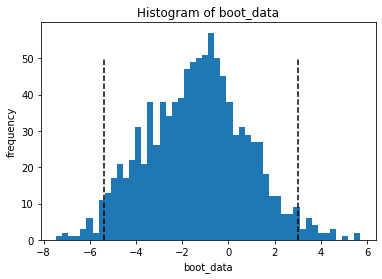

p_value: 0.53


,0
0.025,-5.390045
0.975,3.022801


In [42]:
booted_data_arpu = get_bootstrap(      
    result.query('testgroup == "a"')['revenue'],
    result.query('testgroup == "b"')['revenue'],
    boot_it = 1000,
    statistic = np.mean, 
    bootstrap_conf_level = 0.95)
print("p_value:", booted_data_arpu["p_value"].round(2))
booted_data_arpu["quants"]

Ноль входит в доверительный интервал, значит статистически значимых различий ARPU в группе a и b нет.

<div class="alert alert-block alert-info"
<b>

T-test и Bootstrap не выявили статистически значимых различий ARPPU и ARPU в разрезе групп a и b.
Это значит, что набор акционных предложений никак не повлиял на метрики ARPPU и ARPU.

</b>
</div

<div class="alert alert-block alert-info"
<b>

Таким образом, однозначно ответить на вопрос, какой набор предложений можно считать лучшим довольно непросто. Результаты несколько противоречивые:

* Анализ конверсии показал,что набор акционных предложений для контрольной группы a положительно повлиял на пользователей, побудив их совершать покупки.

* Набор акционных предложений для групп a и b не оказал влияния на ARPPU и ARPU.

* Также стоит отметить, что пользователи в группах a и b по-разному совершали покупки. Медианное значение дохода в группе a примерно в 10 раз меньше, чем в группе b. Размах в группе b много меньше, чем в группе a. В группе а покупки либо слишком дорогие, либо совсем недорогие. В группе b - распределение довольно равномерное.

**На мой взгляд, лучше работать с акционным предложением группы b. Да, конверсия в покупку меньше. Однако доход с пользователей в разы больше, картина покупок равномерная.**

</b>
</div

<div class="alert alert-block alert-danger"
<b>
<ol>
    
**Задача 3**
    
**В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени.**
**В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы.**
**Для получения награды требуется пройти ряд уровней за определенное время.** 
**С помощью каких метрик можно оценить результаты последнего прошедшего события?**

**Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения** 
**уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?**
    
</ol>
</b>
</div>

### **Рассмотрим первую ситуацию, где проводятся тематические события, ограниченные по времени.** 

**Можно использовать следующие метрики:**

* **Дневная аудитория (DAU)** — количество уникальных пользователей, которые зашли в игру в течение суток. С помощью
этой метрики можно сравнить количество пользователей в дни тематических событий и в обычные дни. Так можно будет оценить, 
стремятся ли пользователи зайти в игру в дни тематических событий.


* **Конверсия (conversion rate, CR)** — отношение числа пользователей, которые выполнили какое-либо целевое действие к общему
числу пользователей. Данная метрика покажет, увеличивают ли наличие тематических событий количество новых пользователей.  


* **Sticky Factor, или Stickness (степень вовлечённости, коэффициент «липучести»)** — показатель лояльности аудитории к игре Показывает, как часто клиенты возвращаются в игру в течение недели или месяца.


* **Средняя продолжительность сессии (average session length, ASL)** – среднее арифметическое длин всех сессий. Метрика подскажет, увеличивается ли время, проведенное пользователей в игре в дни тематических событий. 


* **Количество сеансов (сессий) на пользователя** — помогает понять как часто пользователи возвращаются и используют игру.


### **Рассмотрим ситуацию с усложненной механикой, где добавляется откат при каждой неудачной попытке.** 

Наверняка, наличие отката назад и необходимость пользователю начинать все сначала негативно отразится на метриках. 
Особенно если прохождение уровней будет нелегким. На мой взгляд, здесь еще важно, насколько ценными будут призы. 
Если у пользователя мотивация будет невысокая, а достижение результата слишком трудозатратным, ему попросту не захочется в принципе в этом участвовать. Поэтому помимо вышеуказанных метрик стоит добавить следующие:

* **Среднее количество откатов** — покажет, как часто игроки терпят неудачу. Возможно уровни в игре слишком сложные.
* **Средняя продолжительность сессии после отката** — поможет понять, готовы ли пользователи продолжать игру после неудачи.
* **Retention** - метрика, которая показывает, как пользователи возвращаются в продукт (и часто свидетельствует, нравится ли он им).